Baseline results:
               model      RMSE       MAE
0  LinearRegression  0.007768  0.005996
1      RandomForest  0.013503  0.010629


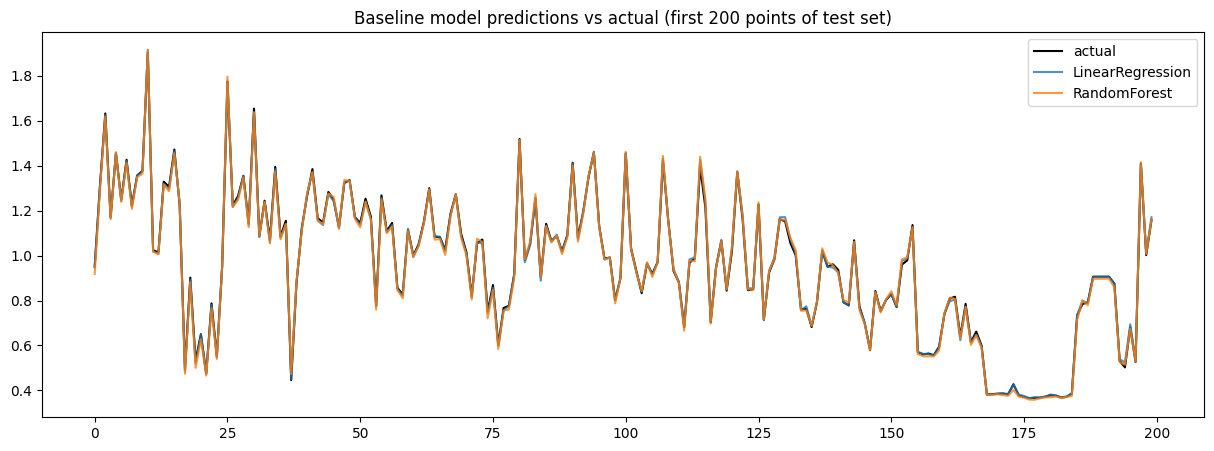


Saved baseline metrics to results/baseline_metrics.csv


In [2]:
# Baseline model: Linear Regression and Random Forest
# This notebook implements simple baseline models to establish initial performance benchmarks for energy demand prediction.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1) Load data
data_path = '../data/cleaned_energy_data.csv'
if not os.path.exists(data_path):
    raise FileNotFoundError(f'Expected data at {data_path} - please run preprocessing or adjust the path')
data = pd.read_csv(data_path, parse_dates=['Datetime'], index_col='Datetime')

# 2) Basic feature engineering
df = data.copy()
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
# target
target = 'Global_active_power'
if target not in df.columns:
    raise KeyError(f'Expected target column "{target}" in data')
# drop NA target rows
df = df.dropna(subset=[target])

# Build feature matrix: start with time features and add any other numeric columns except the target
X = df[['hour', 'dayofweek', 'month']].copy()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target in num_cols:
    num_cols.remove(target)
for c in num_cols:
    if c not in X.columns:
        X[c] = df[c]
y = df[target].copy()

# 3) Time-based train/test split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 4) Scale numeric features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# 5) Fit baseline models
lr = LinearRegression()
lr.fit(X_train_s, y_train)
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_s, y_train)

# 6) Predict and evaluate
y_pred_lr = lr.predict(X_test_s)
y_pred_rf = rf.predict(X_test_s)

def rmse(a, b):
    # sklearn in this environment may not accept the 'squared' kw in some versions; use numpy sqrt of MSE
    return np.sqrt(mean_squared_error(a, b))

metrics = {
    'LinearRegression': {
        'RMSE': rmse(y_test, y_pred_lr),
        'MAE': mean_absolute_error(y_test, y_pred_lr)
    },
    'RandomForest': {
        'RMSE': rmse(y_test, y_pred_rf),
        'MAE': mean_absolute_error(y_test, y_pred_rf)
    }
}

results_df = pd.DataFrame.from_dict(metrics).T.reset_index().rename(columns={'index':'model'})
print('Baseline results:\n', results_df)

# 7) Plot a short window of predictions vs actual for visual check
plot_n = 200  # first N points of the test set to plot
viz = pd.DataFrame({'actual': y_test, 'lr_pred': y_pred_lr, 'rf_pred': y_pred_rf})
plt.figure(figsize=(15,5))
plt.plot(viz['actual'].iloc[:plot_n].values, label='actual', color='black')
plt.plot(viz['lr_pred'].iloc[:plot_n].values, label='LinearRegression', alpha=0.8)
plt.plot(viz['rf_pred'].iloc[:plot_n].values, label='RandomForest', alpha=0.8)
plt.title('Baseline model predictions vs actual (first %d points of test set)' % plot_n)
plt.legend()
plt.show()

# 8) Save metrics for later comparison
os.makedirs('results', exist_ok=True)
results_df.to_csv('results/baseline_metrics.csv', index=False)
print('\nSaved baseline metrics to results/baseline_metrics.csv')

## Visualizations: patterns, predictions, and feature insights

The following plots show time-series demand, feature correlations, actual vs predicted comparisons, feature importance, and sub-metering patterns. Make sure the kernel has run the previous cell so variables like `data`, `X`, `y_test`, and `y_pred_rf` are available.

In [ ]:
# Visualization cell: time series, correlation, actual vs predicted, feature importance, sub-metering
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ensure variables exist
if 'data' not in globals():
    # try to load fallback
    try:
        data = pd.read_csv('../data/cleaned_energy_data.csv', parse_dates=['Datetime'])
    except Exception:
        raise RuntimeError('`data` not found in kernel and fallback load failed')

# If y_test/y_pred exist from previous model run, use them; otherwise skip related plots
has_preds = ('y_test' in globals() and ('y_pred_rf' in globals() or 'y_pred' in globals()))

# 1) Time series visualization (first 500 points)
plt.figure(figsize=(12,5))
ts_n = min(500, len(data))
if 'Datetime' in data.columns:
    x_time = pd.to_datetime(data['Datetime']).iloc[:ts_n]
else:
    # assume index contains datetime
    try:
        x_time = pd.to_datetime(data.index).to_series().iloc[:ts_n]
    except Exception:
        x_time = np.arange(ts_n)

if 'Global_active_power' in data.columns:
    plt.plot(x_time, data['Global_active_power'].iloc[:ts_n].values, label='Global Active Power')
else:
    plt.plot(x_time, data.iloc[:ts_n, 0].values, label='Series (col 0)')
plt.title('Energy Demand Over Time')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

# 2) Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

# 3) Actual vs Predicted (if available)
if has_preds:
    # prefer y_pred_rf or y_pred if available
    y_pred = globals().get('y_pred_rf', globals().get('y_pred'))
    # y_test may be a pandas Series with datetime index; align lengths
    yt = np.asarray(y_test)
    yp = np.asarray(y_pred)
    plt.figure(figsize=(8,5))
    plt.scatter(yt, yp, alpha=0.6)
    plt.xlabel('Actual Global Active Power')
    plt.ylabel('Predicted Global Active Power')
    plt.title('Actual vs Predicted Values')
    plt.grid(True)
    plt.show()
else:
    print('Skipping Actual vs Predicted plot — predictions not available in kernel.')

# 4) Feature importance (if X and model exist)
if 'X' in globals() and ('rf' in globals() or 'xgb' in globals()):
    model = globals().get('rf', globals().get('xgb'))
    try:
        importances = model.feature_importances_
        features = X.columns
        plt.figure(figsize=(8,4))
        sns.barplot(x=importances, y=features)
        plt.title('Feature Importance')
        plt.xlabel('Importance Score')
        plt.show()
    except Exception as e:
        print('Could not plot feature importances:', e)
else:
    print('Skipping feature importance plot — model or X not available in kernel.')

# 5) Sub-metering patterns (if available)
if {'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'}.issubset(set(data.columns)):
    plt.figure(figsize=(10,5))
    n = min(500, len(data))
    plt.plot(data['Sub_metering_1'].iloc[:n].values, label='Sub_metering_1')
    plt.plot(data['Sub_metering_2'].iloc[:n].values, label='Sub_metering_2')
    plt.plot(data['Sub_metering_3'].iloc[:n].values, label='Sub_metering_3')
    plt.title('Energy Consumption by Sub-Meters')
    plt.xlabel('Time')
    plt.ylabel('Energy (Wh)')
    plt.legend()
    plt.show()
else:
    print('Sub-metering columns not found; skipping sub-metering plot.')